# Algorithmic Control Design for Oscillator-Like Systems

In this tutorial, we will use ``kontrol.regulator.oscillator`` submodule to make control regulators for oscillator-like systems.

``kontrol.regulator.oscillator.pid_oscillator()`` is a function that makes PID-like controllers algorithmically based on simple critiera:

1. It returns a derivative controller that critically damps the osciallator.
2. Then it adds proportional/integral (or both) controller such that they match the first UGF of the derivative control. Alternatively, DC gain or integrator time constants can be specified to override the function.

In this tutorial, we will make PID, PD, D control regulators to control the plant

\begin{equation}
P(s) = G_1\frac{\omega_1^2}{s^2 + \omega_1/Q_1 s + \omega_1^2} + G_2\frac{\omega_2^2}{s^2 + \omega_2/Q_2 s + \omega_2^2}\,,
\end{equation}
where $G$s are DC gains, $\omega$s are resonance frequencies, and $Q$s are quality factors. 

The regulator is defined as

\begin{equation}
K_\mathrm{PID}(s) = K_p + K_i/s + K_d s\,,
\end{equation}
where $K_p$, $K_i$, and $K_d$ are the proportional, integral, and derivative gains respectively.

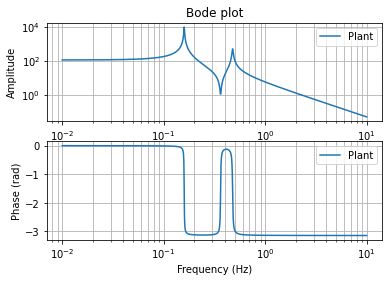

In [4]:
import numpy as np
import control
import matplotlib.pyplot as plt
import kontrol.regulator

## define the plant here
s = control.tf("s")
g1 = 100
w1 = 1
q1 = 100
g2 = 10
w2 = 3
q2 = 50

plant = g1*w1**2 / (s**2 + w1/q1*s + w1**2) + g2*w2**2 / (s**2 + w2/q2*s + w2**2)

f = np.logspace(-2, 1, 1000)
plt.figure(figsize=(6, 4))
plt.subplot(211, title="Bode plot")
plt.loglog(f, abs(plant(1j*2*np.pi*f)), label="Plant")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(212)
plt.semilogx(f, np.angle(plant(1j*2*np.pi*f)), label="Plant")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

Text(0.5, 0, 'Frequency (Hz)')

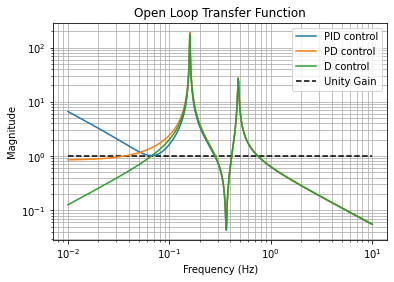

In [2]:
regulator_pid = kontrol.regulator.oscillator.pid(plant, regulator_type="PID")
regulator_pd = kontrol.regulator.oscillator.pid(plant, regulator_type="PD")
# regulator_pi = kontrol.regulator.oscillator.pid(plant, regulator_type="PI")
# regulator_i = kontrol.regulator.oscillator.pid(plant, regulator_type="I")
regulator_d = kontrol.regulator.oscillator.pid(plant, regulator_type="D")

oltf_pid = regulator_pid * plant
oltf_pd = regulator_pd * plant
# oltf_pi = regulator_pi * plant
# oltf_i = regulator_i * plant
oltf_d = regulator_d * plant

plt.title("Open Loop Transfer Function")
plt.loglog(f, abs(oltf_pid(1j*2*np.pi*f)), label="PID control")
plt.loglog(f, abs(oltf_pd(1j*2*np.pi*f)), label="PD control")
# plt.loglog(f, abs(oltf_pi(1j*2*np.pi*f)), label="PI control")
# plt.loglog(f, abs(oltf_i(1j*2*np.pi*f)), label="I control")
plt.loglog(f, abs(oltf_d(1j*2*np.pi*f)), label="D control")
plt.hlines(1, min(f), max(f), color="k", ls="--", label="Unity Gain")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

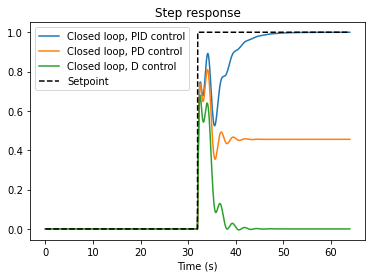

In [3]:
t = np.linspace(0, 64, 1024)

# u = np.zeros_like(t)
u = t > 32
u = u.astype(float)

cltf_pid = oltf_pid / (1+oltf_pid)
cltf_pd = oltf_pd / (1+oltf_pd)
# cltf_pi = oltf_pi / (1+oltf_pi)
# cltf_i = oltf_i / (1+oltf_i)
cltf_d = oltf_d / (1+oltf_d)

_, step_plant = control.forced_response(plant, U=u, T=t)
_, step_pid = control.forced_response(cltf_pid, U=u, T=t)
_, step_pd = control.forced_response(cltf_pd, U=u, T=t)
# _, step_pi = control.forced_response(cltf_pi, U=u, T=t)
# _, step_i = control.forced_response(cltf_i, U=u, T=t)
_, step_d = control.forced_response(cltf_d, U=u, T=t)
plt.title("Step response")

# plt.plot(t, step_plant, label="Plant")
plt.plot(t, step_pid, label="Closed loop, PID control")
plt.plot(t, step_pd, label="Closed loop, PD control")
# plt.plot(t, step_pi, label="Closed loop, PI control")
# plt.plot(t, step_i, label="Closed loop, I control")
plt.plot(t, step_d, label="Closed loop, D control")
plt.plot(t, u, "k--", label="Setpoint")

plt.legend(loc=0)
plt.xlabel("Time (s)")
plt.show()